<a href="https://colab.research.google.com/github/emircancankara/Deep_Learning/blob/main/Tyre_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
dir_path="/content/drive/MyDrive/CV_Datasets/Digital images of defective and good condition tyres"

In [15]:
target_size=(224,224)
waste_labels={"defective":0,"good":1}

In [20]:
import cv2

In [21]:
from imutils import paths
from sklearn.utils import shuffle

In [22]:
def load_datasets(path):
  x=[]
  labels=[]
  image_paths=sorted(list(paths.list_images(path)))

  for image_path in image_paths:
    img=cv2.imread(image_path)
    img=cv2.resize(img,target_size)
    x.append(img)
    label=image_path.split(os.path.sep)[-2]
    labels.append(waste_labels[label])
  x,labels=shuffle(x,labels,random_state=42)

  print(f"X boyutu: {np.array(x).shape}")
  print(f"Label sınıf sayısı: {len(np.unique(labels))} Gözlem sayısı: {len(labels)}")

  return x,labels

In [23]:
x, labels = load_datasets(dir_path)

X boyutu: (1900, 224, 224, 3)
Label sınıf sayısı: 2 Gözlem sayısı: 1900


In [24]:
input_shape=(np.array(x[0]).shape[1],np.array(x[0]).shape[1],3)
print(input_shape)

(224, 224, 3)


In [27]:
def visualize_img(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(10):
    ax=plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels,num_classes=2)[n]==1][0].title())
    plt.axis("off")

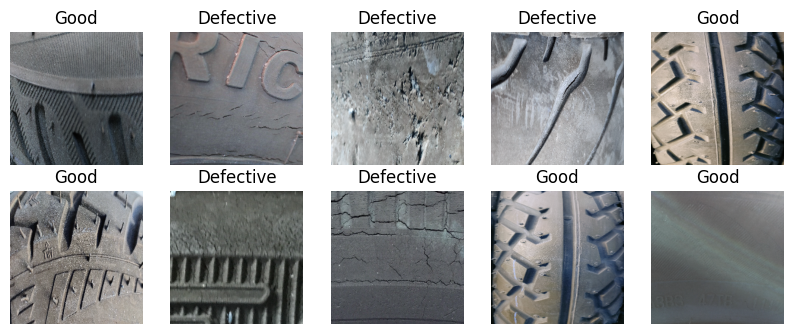

In [28]:
visualize_img(x,labels)

In [29]:
train = ImageDataGenerator(horizontal_flip=True,
                           vertical_flip=True,
                           validation_split=0.1,
                           rescale=1./255,
                           shear_range=0.1,
                           zoom_range=0.1,
                           width_shift_range=0.1,
                           height_shift_range=0.1
                           )

test=ImageDataGenerator(rescale=1/255,
                        validation_split=0.1)

In [31]:
train_generator=train.flow_from_directory(directory=dir_path,
                                          target_size=(target_size),
                                          class_mode="categorical",
                                          subset="training")
test_generator=test.flow_from_directory(directory=dir_path,
                                          target_size=(target_size),
                                         batch_size=251,
                                          class_mode="categorical",
                                          subset="validation")

Found 1711 images belonging to 2 classes.
Found 189 images belonging to 2 classes.


In [32]:
from keras.models import Sequential
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation

model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(input_shape)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

opt = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

In [36]:
from keras.src.callbacks import EarlyStopping,ModelCheckpoint
callbacks=[EarlyStopping(monitor="val_loss",patience=50,verbose=1,mode="min"),
           ModelCheckpoint(filepath="mymodel.h5", monitor="val_loss",mode="min",save_best_only=True, save_weights_only=False, verbose=1)]


In [37]:
history=model.fit_generator(generator=train_generator,
                            epochs=35,
                            validation_data=test_generator,
                            callbacks=callbacks,
                            validation_steps=189//32,
                            steps_per_epoch=1711//32)

<ipython-input-37-e54531df5682>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(generator=train_generator,


Epoch 1/35
53/53 [==============================] - ETA: 0s - loss: 0.7229 - accuracy: 0.5652


Epoch 1: val_loss improved from inf to 0.61137, saving model to mymodel.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 148s 3s/step - loss: 0.7229 - accuracy: 0.5652 - val_loss: 0.6114 - val_accuracy: 0.6825
Epoch 2/35
53/53 [==============================] - ETA: 0s - loss: 0.6330 - accuracy: 0.6587

53/53 [==============================] - 110s 2s/step - loss: 0.6330 - accuracy: 0.6587
Epoch 3/35
53/53 [==============================] - ETA: 0s - loss: 0.6134 - accuracy: 0.6683

53/53 [==============================] - 112s 2s/step - loss: 0.6134 - accuracy: 0.6683
Epoch 4/35
53/53 [==============================] - ETA: 0s - loss: 0.6159 - accuracy: 0.6763

53/53 [==============================] - 113s 2s/step - loss: 0.6159 - accuracy: 0.6763
Epoch 5/35
53/53 [==============================] - ETA: 0s - loss: 0.5841 - accuracy: 0.6928

53/53 [==============================] - 111s 2s/step - loss: 0.5841 - accuracy: 0.6928
Epoch 6/35
53/53 [==============================] - ETA: 0s - loss: 0.5811 - accuracy: 0.6980

53/53 [==============================] - 107s 2s/step - loss: 0.5811 - accuracy: 0.6980
Epoch 7/35
53/53 [==============================] - ETA: 0s - loss: 0.5871 - accuracy: 0.6897

53/53 [==============================] - 101s 2s/step - loss: 0.5871 - accuracy: 0.6897
Epoch 8/35
53/53 [==============================] - ETA: 0s - loss: 0.5652 - accuracy: 0.7165

53/53 [==============================] - 100s 2s/step - loss: 0.5652 - accuracy: 0.7165
Epoch 9/35
53/53 [==============================] - ETA: 0s - loss: 0.5659 - accuracy: 0.7159

53/53 [==============================] - 97s 2s/step - loss: 0.5659 - accuracy: 0.7159
Epoch 10/35
53/53 [==============================] - ETA: 0s - loss: 0.5587 - accuracy: 0.7266

53/53 [==============================] - 98s 2s/step - loss: 0.5587 - accuracy: 0.7266
Epoch 11/35
53/53 [==============================] - ETA: 0s - loss: 0.5603 - accuracy: 0.7165

53/53 [==============================] - 98s 2s/step - loss: 0.5603 - accuracy: 0.7165
Epoch 12/35
53/53 [==============================] - ETA: 0s - loss: 0.5480 - accuracy: 0.7332

53/53 [==============================] - 96s 2s/step - loss: 0.5480 - accuracy: 0.7332
Epoch 13/35
53/53 [==============================] - ETA: 0s - loss: 0.5406 - accuracy: 0.7356

53/53 [==============================] - 98s 2s/step - loss: 0.5406 - accuracy: 0.7356
Epoch 14/35
53/53 [==============================] - ETA: 0s - loss: 0.5456 - accuracy: 0.7350

53/53 [==============================] - 99s 2s/step - loss: 0.5456 - accuracy: 0.7350
Epoch 15/35
53/53 [==============================] - ETA: 0s - loss: 0.5449 - accuracy: 0.7242

53/53 [==============================] - 97s 2s/step - loss: 0.5449 - accuracy: 0.7242
Epoch 16/35
53/53 [==============================] - ETA: 0s - loss: 0.5294 - accuracy: 0.7415

53/53 [==============================] - 98s 2s/step - loss: 0.5294 - accuracy: 0.7415
Epoch 17/35
53/53 [==============================] - ETA: 0s - loss: 0.5272 - accuracy: 0.7457

53/53 [==============================] - 98s 2s/step - loss: 0.5272 - accuracy: 0.7457
Epoch 18/35
53/53 [==============================] - ETA: 0s - loss: 0.4977 - accuracy: 0.7552

53/53 [==============================] - 98s 2s/step - loss: 0.4977 - accuracy: 0.7552
Epoch 19/35
53/53 [==============================] - ETA: 0s - loss: 0.5126 - accuracy: 0.7504

53/53 [==============================] - 96s 2s/step - loss: 0.5126 - accuracy: 0.7504
Epoch 20/35
53/53 [==============================] - ETA: 0s - loss: 0.5031 - accuracy: 0.7606

53/53 [==============================] - 98s 2s/step - loss: 0.5031 - accuracy: 0.7606
Epoch 21/35
53/53 [==============================] - ETA: 0s - loss: 0.5017 - accuracy: 0.7534

53/53 [==============================] - 98s 2s/step - loss: 0.5017 - accuracy: 0.7534
Epoch 22/35
53/53 [==============================] - ETA: 0s - loss: 0.4947 - accuracy: 0.7552

53/53 [==============================] - 99s 2s/step - loss: 0.4947 - accuracy: 0.7552
Epoch 23/35
53/53 [==============================] - ETA: 0s - loss: 0.4617 - accuracy: 0.7856

53/53 [==============================] - 98s 2s/step - loss: 0.4617 - accuracy: 0.7856
Epoch 24/35
53/53 [==============================] - ETA: 0s - loss: 0.4882 - accuracy: 0.7707

53/53 [==============================] - 97s 2s/step - loss: 0.4882 - accuracy: 0.7707
Epoch 25/35
53/53 [==============================] - ETA: 0s - loss: 0.4556 - accuracy: 0.7856

53/53 [==============================] - 96s 2s/step - loss: 0.4556 - accuracy: 0.7856
Epoch 26/35
53/53 [==============================] - ETA: 0s - loss: 0.4589 - accuracy: 0.7862

53/53 [==============================] - 98s 2s/step - loss: 0.4589 - accuracy: 0.7862
Epoch 27/35
53/53 [==============================] - ETA: 0s - loss: 0.4715 - accuracy: 0.7772

53/53 [==============================] - 98s 2s/step - loss: 0.4715 - accuracy: 0.7772
Epoch 28/35
53/53 [==============================] - ETA: 0s - loss: 0.4533 - accuracy: 0.7838

53/53 [==============================] - 97s 2s/step - loss: 0.4533 - accuracy: 0.7838
Epoch 29/35
53/53 [==============================] - ETA: 0s - loss: 0.4358 - accuracy: 0.8052

53/53 [==============================] - 98s 2s/step - loss: 0.4358 - accuracy: 0.8052
Epoch 30/35
53/53 [==============================] - ETA: 0s - loss: 0.4422 - accuracy: 0.7909

53/53 [==============================] - 98s 2s/step - loss: 0.4422 - accuracy: 0.7909
Epoch 31/35
53/53 [==============================] - ETA: 0s - loss: 0.4236 - accuracy: 0.8112

53/53 [==============================] - 96s 2s/step - loss: 0.4236 - accuracy: 0.8112
Epoch 32/35
53/53 [==============================] - ETA: 0s - loss: 0.3870 - accuracy: 0.8285

53/53 [==============================] - 96s 2s/step - loss: 0.3870 - accuracy: 0.8285
Epoch 33/35
53/53 [==============================] - ETA: 0s - loss: 0.4050 - accuracy: 0.8100

53/53 [==============================] - 98s 2s/step - loss: 0.4050 - accuracy: 0.8100
Epoch 34/35
53/53 [==============================] - ETA: 0s - loss: 0.3972 - accuracy: 0.8219

53/53 [==============================] - 96s 2s/step - loss: 0.3972 - accuracy: 0.8219
Epoch 35/35
53/53 [==============================] - ETA: 0s - loss: 0.3993 - accuracy: 0.8166

53/53 [==============================] - 96s 2s/step - loss: 0.3993 - accuracy: 0.8166


In [38]:
model.save_weights("tyre_quality.h5")

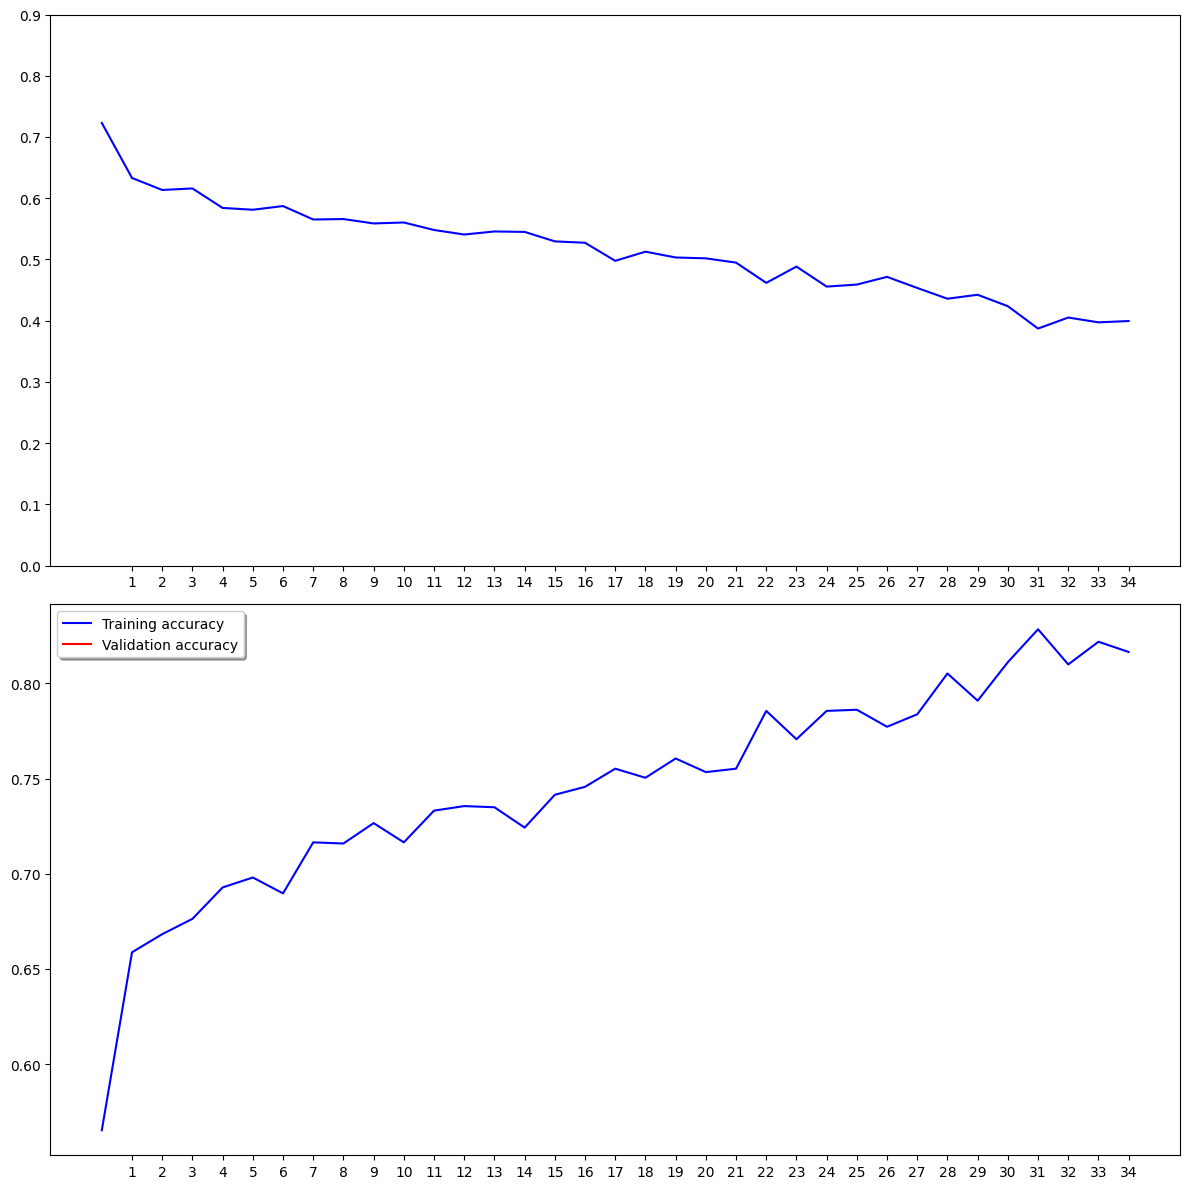

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 35, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 35, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [43]:
loss, acc=model.evaluate(test_generator, batch_size=32)
print(100*acc)

1/1 [==============================] - 7s 7s/step - loss: 0.5873 - accuracy: 0.7460
74.60317611694336
